In [1]:
import json
import numpy as np 
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt 
from matplotlib.ticker import MultipleLocator
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler

In [2]:
# read in data, configure dataframe
target_directory = '../data/full_opt_15KeV'

x_dictlist, y_dictlist = [], []

for json_file in os.listdir(target_directory):
    if json_file[-4:] != 'json':
        continue

    with open(f'{target_directory}/{json_file}') as f:
        samples = json.load(f)['samples']
        dvars = [samples[i]['dvar'] for i in samples.keys()]
        objs = [samples[i]['obj'] for i in samples.keys()]
        
        x_dictlist += dvars
        y_dictlist += objs
        
x_df = pd.DataFrame(x_dictlist).apply(pd.to_numeric)
y_df = pd.DataFrame(y_dictlist).apply(pd.to_numeric)

In [3]:
features_dict = {
    "DVAR1": "Bmax",
    "DVAR2": "mX1",
    "DVAR3": "mX2",
    "DVAR4": "mY1",
    "DVAR5": "mY2",
    "DVAR6": "mtau1",
    "DVAR7": "mtau2",
    "DVAR8": "PhiY1",
    "DVAR9": "PhiY2",
    "DVAR10": "Phitau1",
    "DVAR11": "Phitau2",
    "DVAR12": "mY3ref",
    "DVAR13": "PhiY3ref",
    "DVAR14": "Eref",
}

response_dict = {
    "OBJ1": "transmission",
    "OBJ2": "output energy",
    "OBJ3": "RFQ length",
    "OBJ4": "longitudinal emittance",
    "OBJ5": "x-emittance",
    "OBJ6": "y-emittance",
}

## Correlation matrices

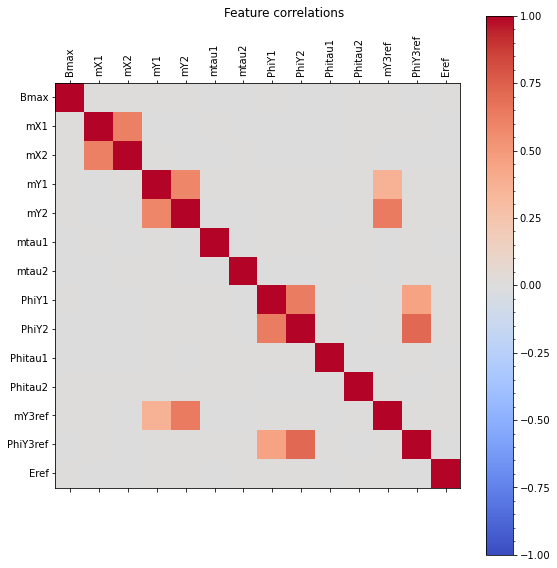

In [4]:
cmap = cm.coolwarm

# x
ticklabels = [''] + [features_dict[f'DVAR{i+1}'] for i in range(x_df.shape[1])]
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
corrplot = ax.matshow(x_df.corr(), cmap=cmap)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels(ticklabels, rotation=90)
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_yticklabels(ticklabels)
cbar = fig.colorbar(corrplot, ax=ax)
cbar.minorticks_on()

cbar.mappable.set_clim(-1., 1.)

fig.suptitle("Feature correlations")
plt.tight_layout()
plt.show()

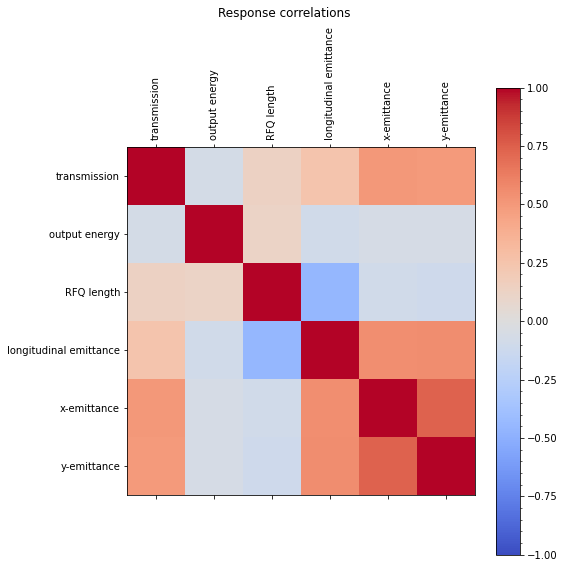

In [5]:
# y
ticklabels = [''] + [response_dict[f'OBJ{i+1}'] for i in range(y_df.shape[1])]
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
corrplot = ax.matshow(y_df.corr(), cmap=cmap)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels(ticklabels, rotation=90)
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_yticklabels(ticklabels)
cbar = fig.colorbar(corrplot, ax=ax)
cbar.minorticks_on()

cbar.mappable.set_clim(-1., 1.)

fig.suptitle("Response correlations")
plt.tight_layout()
plt.show()

## Distributions and rescaling

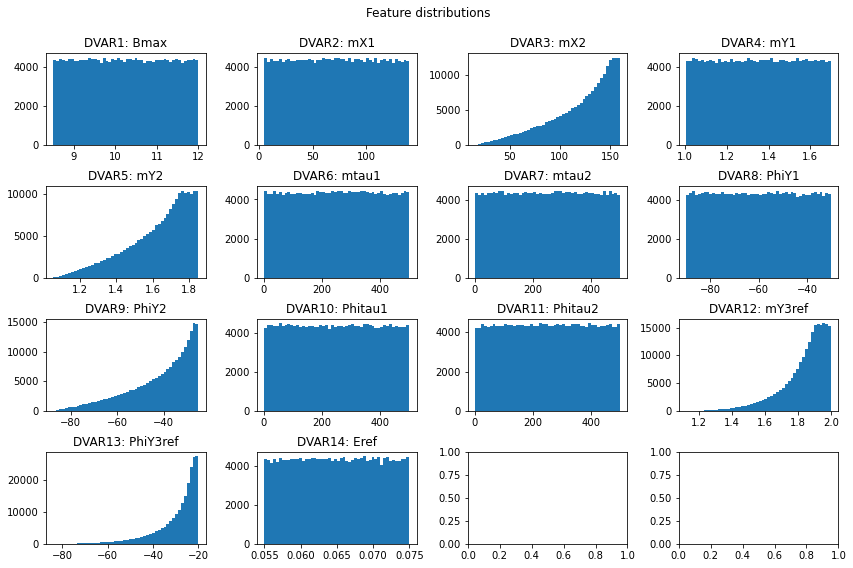

In [6]:
# x
fig, axs = plt.subplots(4, 4, figsize=(12,8))

for i in range(x_df.shape[1]):
    ax = axs.flatten()[i]
    ax.hist(x_df.values[:, i], bins=50)
    ax.set_title(f'DVAR{i+1}: ' + features_dict[f'DVAR{i+1}'])
    
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.suptitle('Feature distributions')
plt.show()

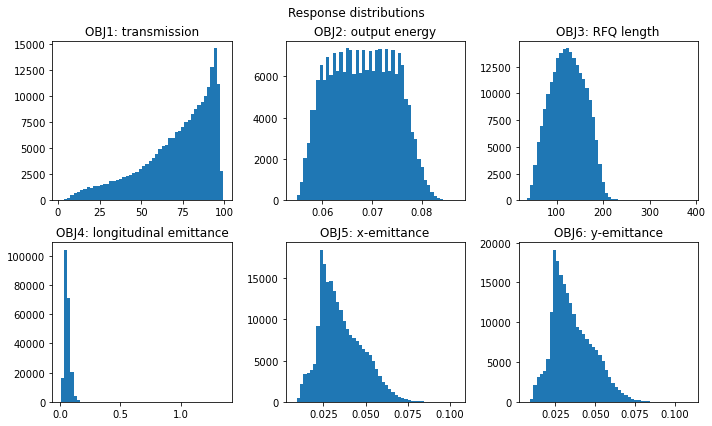

In [7]:
# y
fig, axs = plt.subplots(2, 3, figsize=(10,6))

for i in range(y_df.shape[1]):
    ax = axs.flatten()[i]
    ax.hist(y_df.values[:, i], bins=50)
    ax.set_title(f'OBJ{i+1}: ' + response_dict[f'OBJ{i+1}'])
    
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.suptitle('Response distributions')
plt.show()

$\texttt{DVAR3}$ is determined in the following way. For some buffer $\eta_3 = 10.$:

$$ \texttt{DVAR2} \sim \textrm{Uniform}(L_2, U_2) $$
$$ \texttt{DVAR3} \sim \textrm{Uniform}(\texttt{DVAR2} + \eta_3, U_3)$$

Which means that we can introduce 
$$\texttt{DVAR3}' \equiv \frac{\texttt{DVAR3} - (\texttt{DVAR2} + \eta_3)}{U_3 - (\texttt{DVAR2} + \eta_3)} \sim \textrm{Uniform} (0, 1)$$

In [8]:
def get_prime_dvar_values(to_transform, dynamic_lower_bound, strict_upper_bound):
    return (to_transform - dynamic_lower_bound) / (strict_upper_bound - dynamic_lower_bound)

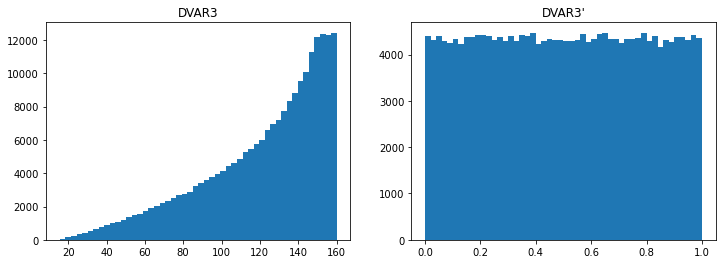

In [9]:
# transform dvar3
max_dvar_3 = 160
eta_3 = 10.
dvar_3_prime = get_prime_dvar_values(x_df['DVAR3'], eta_3 + x_df['DVAR2'], max_dvar_3)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(x_df['DVAR3'], bins=50)
axs[0].set_title('DVAR3')

axs[1].hist(dvar_3_prime, bins=50)
axs[1].set_title('DVAR3\'')
plt.show()

Similarly, the $\texttt{DVAR4} < \texttt{DVAR5} < \texttt{DVAR12}$ relationship means these are correlated. For $\eta_5 = 0.05$ and $\eta_{12} = 0.05$:

$$ \texttt{DVAR4} \sim \textrm{Uniform} (L_4, U_4) $$
$$ \texttt{DVAR5} \sim \textrm{Uniform} (\texttt{DVAR4} + \eta_5, U_5)$$
$$ \texttt{DVAR12} \sim \textrm{Uniform} (\texttt{DVAR12} + \eta_{12}, U_{12})$$

And for some buffers $\eta_9 = 2.5$ and $\eta_{13} = 2.5$:

$$ \texttt{DVAR8} \sim \textrm{Uniform}(L_8, U_8) $$
$$ \texttt{DVAR9} \sim \textrm{Uniform}(\texttt{DVAR8} + \eta_9, U_9)$$
$$ \texttt{DVAR13} \sim \textrm{Uniform}(\texttt{DVAR9} + \eta_{13}, U_{13})$$

Thus, for $\texttt{DVAR5}, \texttt{DVAR9}, \texttt{DVAR12}, \texttt{DVAR13}$ we can transform to the primed definitions using the same procedure outlined above. Importantly, note that the primed design variables are decorrelated from the unprimed design variables.

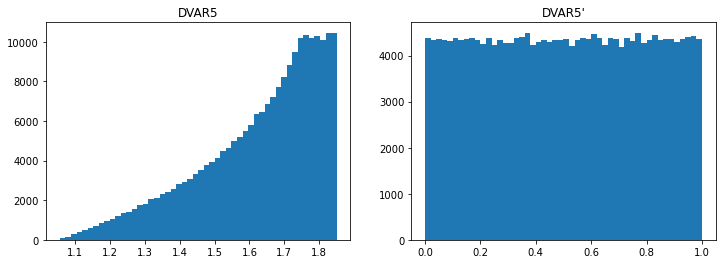

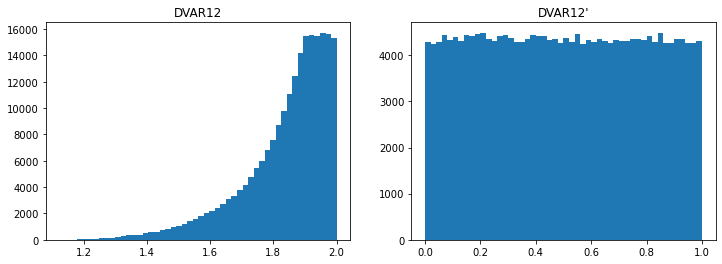

In [10]:
# transform dvar5
max_dvar_5 = 1.85
eta_5 = 0.05
dvar_5_prime = get_prime_dvar_values(x_df['DVAR5'], x_df['DVAR4'] + eta_5, max_dvar_5)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(x_df['DVAR5'], bins=50)
axs[0].set_title('DVAR5')

axs[1].hist(dvar_5_prime, bins=50)
axs[1].set_title('DVAR5\'')
plt.show()

# transform dvar12
max_dvar_12 = 2.0
eta_12 = 0.05
dvar_12_prime = get_prime_dvar_values(x_df['DVAR12'], x_df['DVAR5'] + eta_12, max_dvar_12)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(x_df['DVAR12'], bins=50)
axs[0].set_title('DVAR12')

axs[1].hist(dvar_12_prime, bins=50)
axs[1].set_title('DVAR12\'')
plt.show()

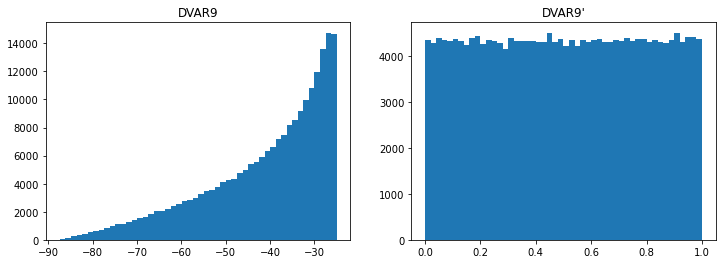

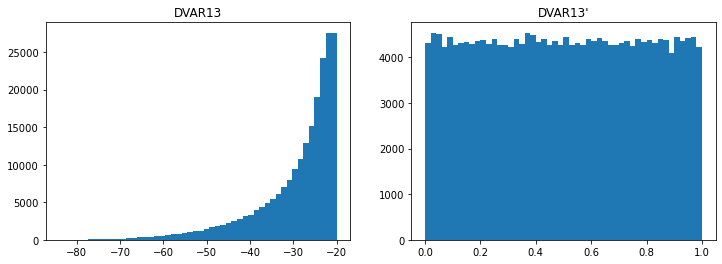

In [11]:
# transform dvar9
max_dvar_9 = -25.
eta_9 = 2.5
dvar_9_prime = get_prime_dvar_values(x_df['DVAR9'], x_df['DVAR8'] + eta_9, max_dvar_9)

fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[0].hist(x_df['DVAR9'], bins=50)
axs[0].set_title('DVAR9')

axs[1].hist(dvar_9_prime, bins=50)
axs[1].set_title('DVAR9\'')
plt.show()

# transform dvar13
max_dvar_13 = -20.
eta_13 = 2.5
dvar_13_prime = get_prime_dvar_values(x_df['DVAR13'], x_df['DVAR9'] + eta_13, max_dvar_13)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(x_df['DVAR13'], bins=50)
axs[0].set_title('DVAR13')

axs[1].hist(dvar_13_prime, bins=50)
axs[1].set_title('DVAR13\'')
plt.show()

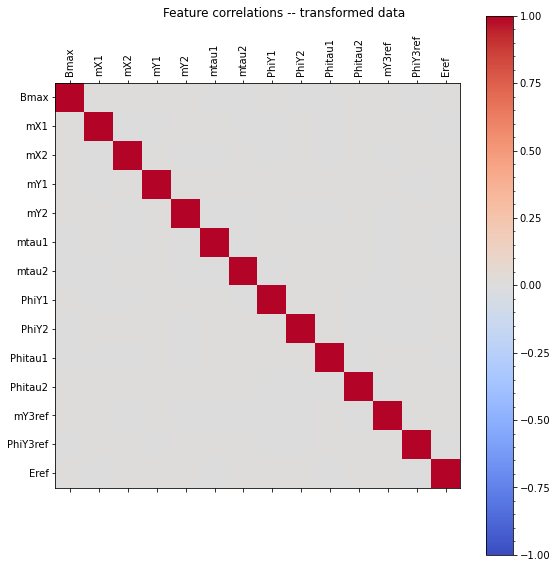

In [12]:
# transfomred data correlation plot
cmap = cm.coolwarm

x_df_2 = x_df.copy()
x_df_2['DVAR3'] = dvar_3_prime
x_df_2['DVAR5'] = dvar_5_prime
x_df_2['DVAR9'] = dvar_9_prime
x_df_2['DVAR12'] = dvar_12_prime
x_df_2['DVAR13'] = dvar_13_prime

# x
ticklabels = [''] + [features_dict[f'DVAR{i+1}'] for i in range(x_df_2.shape[1])]
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
corrplot = ax.matshow(x_df_2.corr(), cmap=cmap)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels(ticklabels, rotation=90)
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_yticklabels(ticklabels)
cbar = fig.colorbar(corrplot, ax=ax)
cbar.minorticks_on()

cbar.mappable.set_clim(-1., 1.)

fig.suptitle("Feature correlations -- transformed data")
plt.tight_layout()
plt.show()

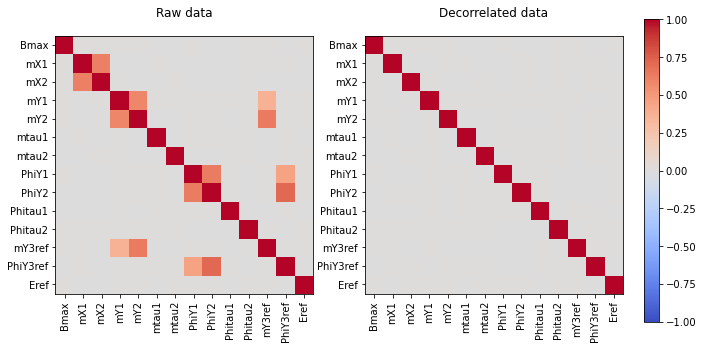

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
for i, ax in enumerate(axes.flatten()):
    if i == 0:
        im = ax.matshow(x_df.corr(), cmap=cmap, vmin=-1., vmax=1.)
        ax.set_title('Raw data')
    else:
        im = ax.matshow(x_df_2.corr(), cmap=cmap, vmin=-1., vmax=1.)
        ax.set_title('Decorrelated data')
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.set_xticklabels(ticklabels, rotation=90)
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.set_yticklabels(ticklabels)
    ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    
plt.tight_layout()
fig.subplots_adjust(right=0.87)
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('correlationmatrix.png', dpi=400)
plt.show()


Great. Our variables are decorrelated.

## Smoothness of the feature / response space?

My thinking here is that maybe the reason that the neural networks haven't been doing a good job understanding the relationship between the RFQ design variabels and objectives is because there could be non-smoothness in the function that could lend the relationship difficult to predict.

The purpose of this analysis is to test the hypothesis of local smoothness; that is, small changes in the design variables should be accompanied by small changes in the objectives.

To this end, I compute the Euclidean distance between two non-equal vectors in the feature space, and compare this value with the corresponding Euclidean distance between the two data entry's objective values. The data that I use for this is scaled to allow for easy interperetability between any two feature vectors. If the relationship is more jagged than we expect, which could give difficult to the neural network, then small changes in the feature space would be associated with lare changes in the response space.

In [21]:
# min max scale features and response
x_scaled_df = pd.DataFrame(MinMaxScaler().fit_transform(x_df_2), columns=x_df_2.columns)
y_scaled_df = pd.DataFrame(MinMaxScaler().fit_transform(y_df), columns=y_df.columns)

In [90]:
subsample_range = [0.1, 0.9]
subsample_mask = ((x_scaled_df >= subsample_range[0]) & (x_scaled_df <= subsample_range[1])).all(axis=1)

x_scaled_subsample_df = x_scaled_df[subsample_mask]; y_scaled_subsample_df = y_scaled_df[subsample_mask]

In [91]:
x_distances = cdist(x_scaled_subsample_df, x_scaled_subsample_df, "euclid")
y_distances = cdist(y_scaled_subsample_df, y_scaled_subsample_df, "euclid")

# drop diagonal elements and flatten
def drop_diags_and_flatten(A):
    return A[~np.eye(A.shape[0],dtype=bool)]

x_distances = drop_diags_and_flatten(x_distances)
y_distances = drop_diags_and_flatten(y_distances)

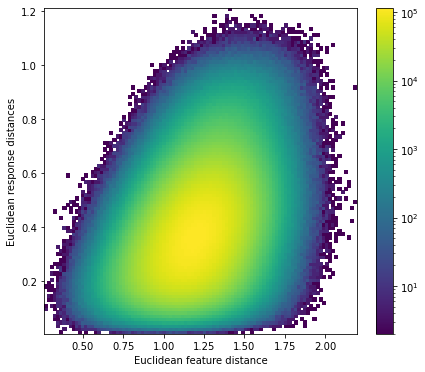

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))

hist = ax.hist2d(x_distances, y_distances, norm=mpl.colors.LogNorm(), bins=100)
ax.set_xlabel('Euclidean feature distance')
ax.set_ylabel('Euclidean response distances')
fig.colorbar(hist[3], ax=ax)
plt.show()

First, note the limitations of the data. The features that I used are normalized so that they are all uncorrelated and look like a Uniform distribution. There are 14 design variables that are treated as features in this analysis. Thus, data points that are close together in the feature space are rare. For instance, the probability of any one feature vector to have all component values within some range of width $0.1$ is $0.1^{14} = 10^{-14}$.

That said, the plot that I show above demonstrates that for any two data points, the Euclidean distance of their objective values is somewhat bounded by the Euclidean distance of their response values. Is this true for all responses separately?